In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import LogRegAC.logRegAC as logRegAC
import LogRegAC.utilsAC as utilsAC

In [133]:
data = pd.read_csv('data.csv', header=None)
print(data.shape)
data.head()

(200, 3)


,0,1,2
0,6,32,1
1,26,39,1
2,2,38,1
3,25,39,1
4,3,35,1


In [134]:
data = data.sample(frac=1).reset_index(drop=True)
data_x = data.iloc[:, 0:-1]
data_y = data.iloc[:, -1].replace(-1, 0)

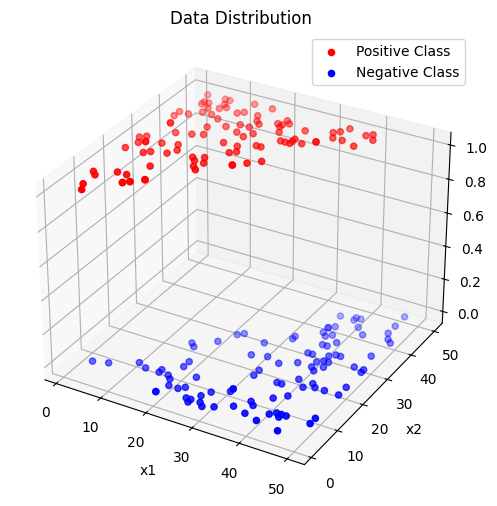

In [135]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(
    [data_x.iloc[i, 0] for i in range(len(data_x)) if data_y.iloc[i] == 1], 
    [data_x.iloc[i, 1] for i in range(len(data_x)) if data_y.iloc[i] == 1], 
    [i for i in data_y if i == 1], c='red', label='Positive Class')
ax.scatter3D(
    [data_x.iloc[i, 0] for i in range(len(data_x)) if data_y.iloc[i] != 1], 
    [data_x.iloc[i, 1] for i in range(len(data_x)) if data_y.iloc[i] != 1], 
    [i for i in data_y if i != 1], c='blue', label='Negative Class')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.legend()
plt.title('Data Distribution')
plt.show()

In [136]:
train_x, train_y, test_x, test_y = utilsAC.splitTrainTest(data_x, data_y, 0.8)
train_x, train_min, train_max = utilsAC.normMinMax(train_x, mode='train')
test_x = utilsAC.normMinMax(test_x, mode='test', train_min=train_min, train_max=train_max)

In [137]:
logReg1 = logRegAC.LogReg(lr=0.01, max_iter=1000)
logReg1.fit(train_x, train_y, iter_step=100)
pred = logReg1.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred)['f1'])

Iteration     0 | Cost:  0.664
Iteration   100 | Cost:  0.203
Iteration   200 | Cost:  0.156
Iteration   300 | Cost:  0.135
Iteration   400 | Cost:  0.122
Iteration   500 | Cost:  0.114
Iteration   600 | Cost:  0.107
Iteration   700 | Cost:  0.102
Iteration   800 | Cost:  0.098
Iteration   900 | Cost:  0.095
Iteration  1000 | Cost:  0.092
F1 Score:  0.9795918367346939


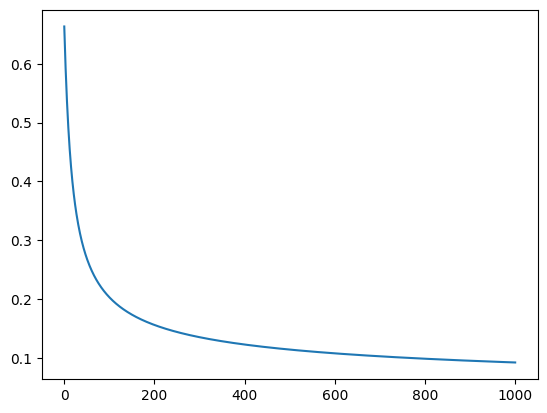

In [138]:
plt.plot(logReg1.get_cost_hist())

In [139]:
trained_weights = logReg1.get_params()
cf_info = utilsAC.get_performance_measure(data_y, logReg1.predict(data_x))
cf_matrix = [[cf_info['tn'], cf_info['fn']], [cf_info['fp'], cf_info['tp']]]

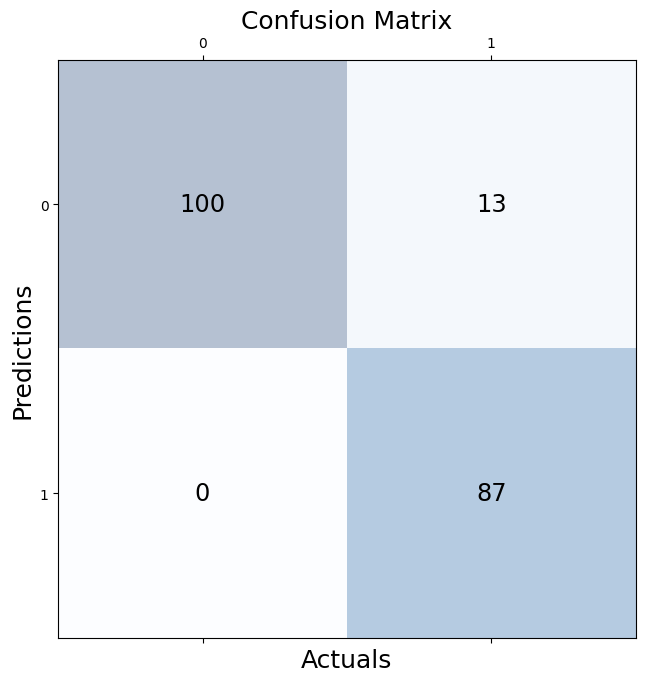

In [140]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(cf_matrix)):
    for j in range(len(cf_matrix[i])):
        ax.text(x=j, y=i,s=cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

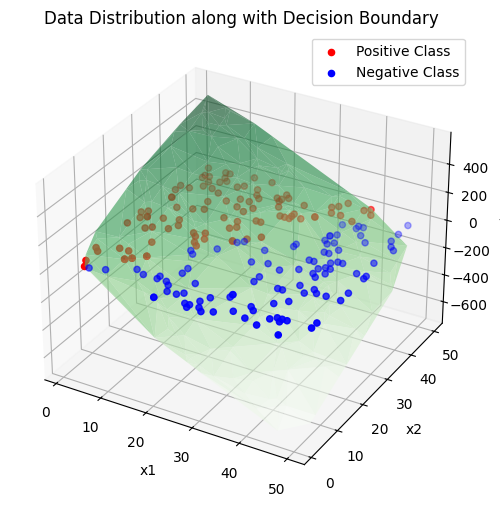

In [141]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(
    [data_x.iloc[i, 0] for i in range(len(data_x)) if data_y.iloc[i] == 1], 
    [data_x.iloc[i, 1] for i in range(len(data_x)) if data_y.iloc[i] == 1], 
    [i for i in data_y if i == 1], marker='o', c='red', label='Positive Class')
ax.scatter3D(
    [data_x.iloc[i, 0] for i in range(len(data_x)) if data_y.iloc[i] != 1], 
    [data_x.iloc[i, 1] for i in range(len(data_x)) if data_y.iloc[i] != 1], 
    [i for i in data_y if i != 1], marker='o', c='blue', label='Negative Class')

plot_x = np.c_[np.ones((data_x.shape[0], 1)), data_x]
plot_pred = np.dot(plot_x, trained_weights).flatten()
ax.plot_trisurf(data_x[0], data_x[1], plot_pred,
                alpha=0.6,
                cmap='Greens')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.legend()
plt.title('Data Distribution along with Decision Boundary')
plt.show()